In [ ]:
#https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft
#!pip install graphviz
#!conda install --yes -c conda-forge graphviz
!pip install gcsfs==2022.5.0 

# Minimal example to get `dask.distributed` working

* No `dask_geopandas` installed in `dask.distributed`...will have to ask Andrew. For now, test `dask.dataframe` only.
* Move all functions into this notebook to simplify for now.
* Read in multiple tabular datasets, merge, and do aggregation.
* Get task graph loaded (`bus_service_utils` has the `pip` and `conda` requirements)
* Can we test `dask.delayed` and `dask futures`?

In [1]:
import dask.dataframe as dd
import gcsfs
import pandas as pd

from calitp.storage import get_fs, is_cloud
from dask.distributed import Client

analysis_date = "2022-10-12"
RT_GCS = 'gs://calitp-analytics-data/data-analyses/rt_delay/compiled_cached_views/'

In [2]:
def categorize_time_of_day(value: int ) -> str:
    if isinstance(value, int):
        hour = value
    if hour < 4:
        return "Owl"
    elif hour < 7:
        return "Early AM"
    elif hour < 10:
        return "AM Peak"
    elif hour < 15:
        return "Midday"
    elif hour < 20:
        return "PM Peak"
    else:
        return "Evening"

In [3]:
def merge_stop_times_to_trips(
    stop_times: dd.DataFrame, 
    trips: dd.DataFrame) -> dd.DataFrame:   
    
    shape_id_cols = ["calitp_itp_id", "shape_id"]

    merged = dd.merge(
        stop_times,
        trips[shape_id_cols + ["trip_id"]].drop_duplicates(),
        on = ["calitp_itp_id", "trip_id"]
    )
    
    # Map to time-of-day
    stop_times_binned = merged.assign(
        time_of_day=merged.apply(
            lambda x: categorize_time_of_day(x.departure_hour), axis=1, 
            meta=('time_of_day', 'str'))
    )
    
    # Calculate the number of arrivals by time-of-day
    arrivals = (stop_times_binned
                .groupby(shape_id_cols + ["time_of_day"])
                .agg({"stop_id": "count"})
                .reset_index()
         )
    
    return arrivals

In [4]:
client = Client("dask-scheduler.dask.svc.cluster.local:8786")
client

<Client: 'tcp://10.96.14.2:8786' processes=3 threads=6, memory=46.91 GiB>

Show task graph for just 1 operator.

* low-level: `.visualize()` 
* high-level: `.dask.visualize()`

In [5]:
stop_times = dd.read_parquet(f"{RT_GCS}st_{analysis_date}.parquet")
trips = dd.read_parquet(f"{RT_GCS}trips_{analysis_date}.parquet")

In [6]:
# Can we repartition and have it show up in task graph?
stop_times = stop_times.repartition(npartitions=5)
trips = trips.repartition(npartitions=5)

In [7]:
merged = merge_stop_times_to_trips(stop_times, trips)

In [8]:
# Repartition in the merged?
merged = merged.repartition(npartitions=3)

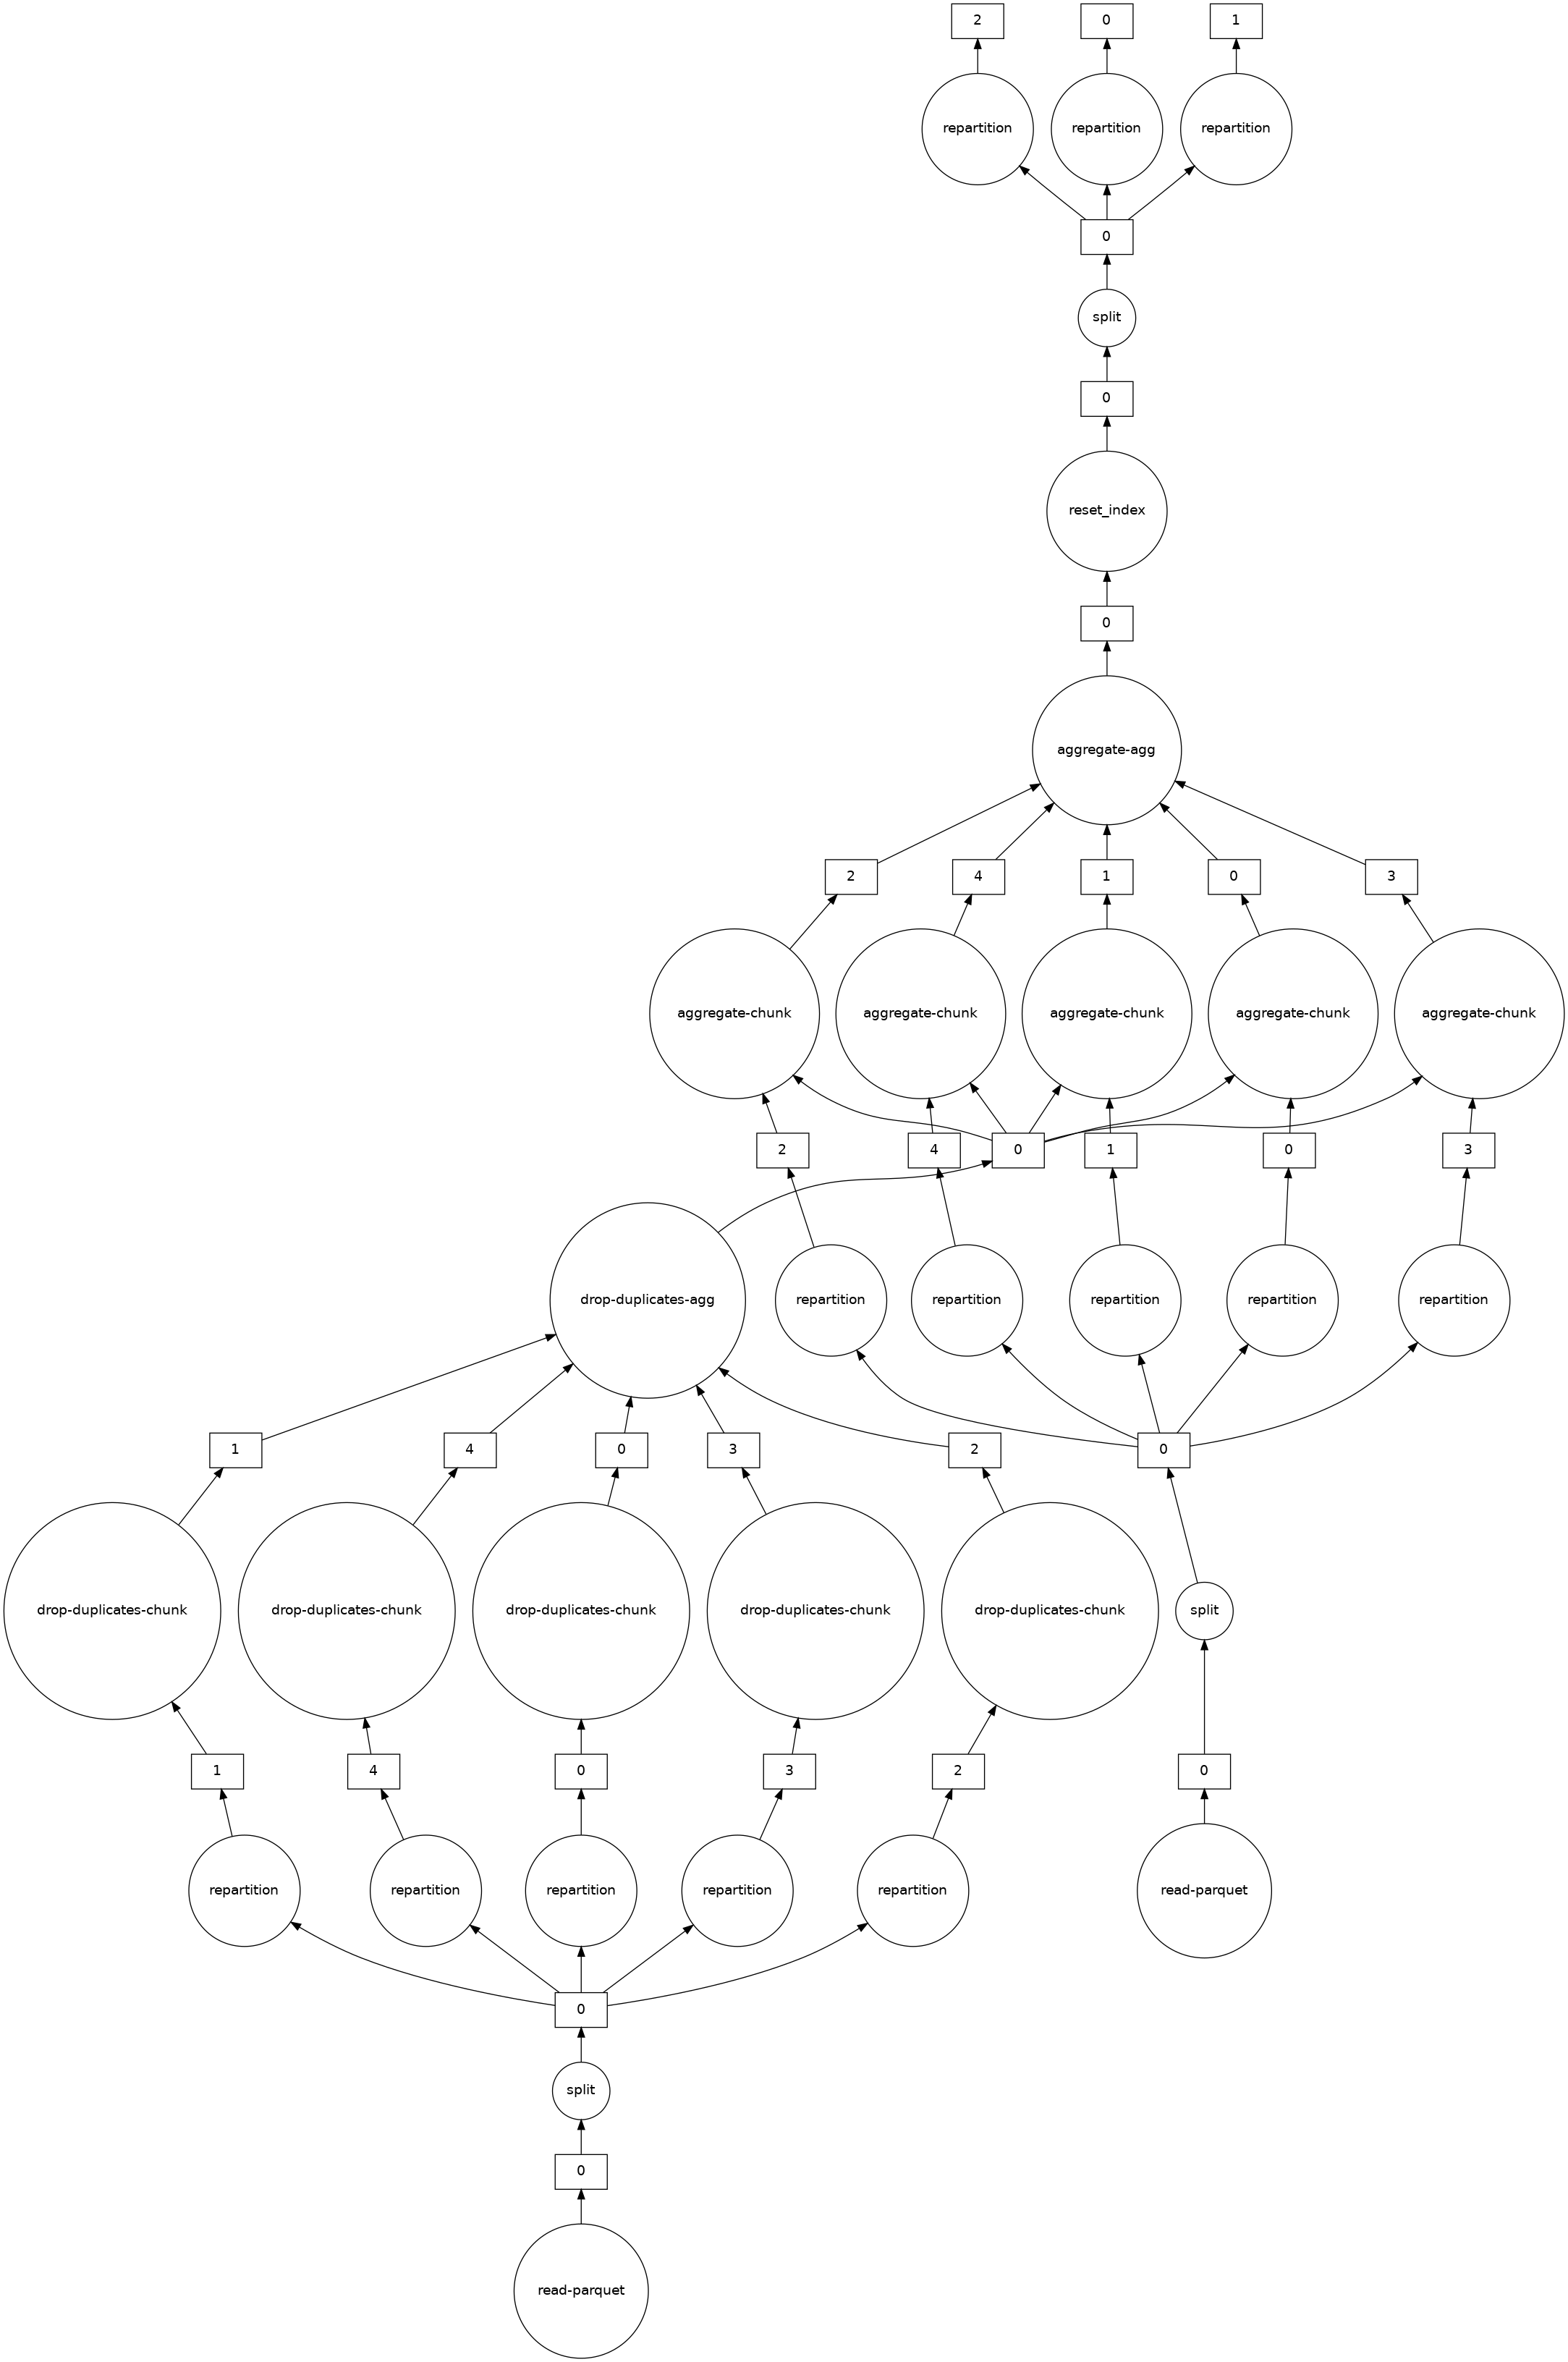

In [9]:
# Low-level graph - looks good, repartitioning worked
merged.visualize(optimize_graph=True)

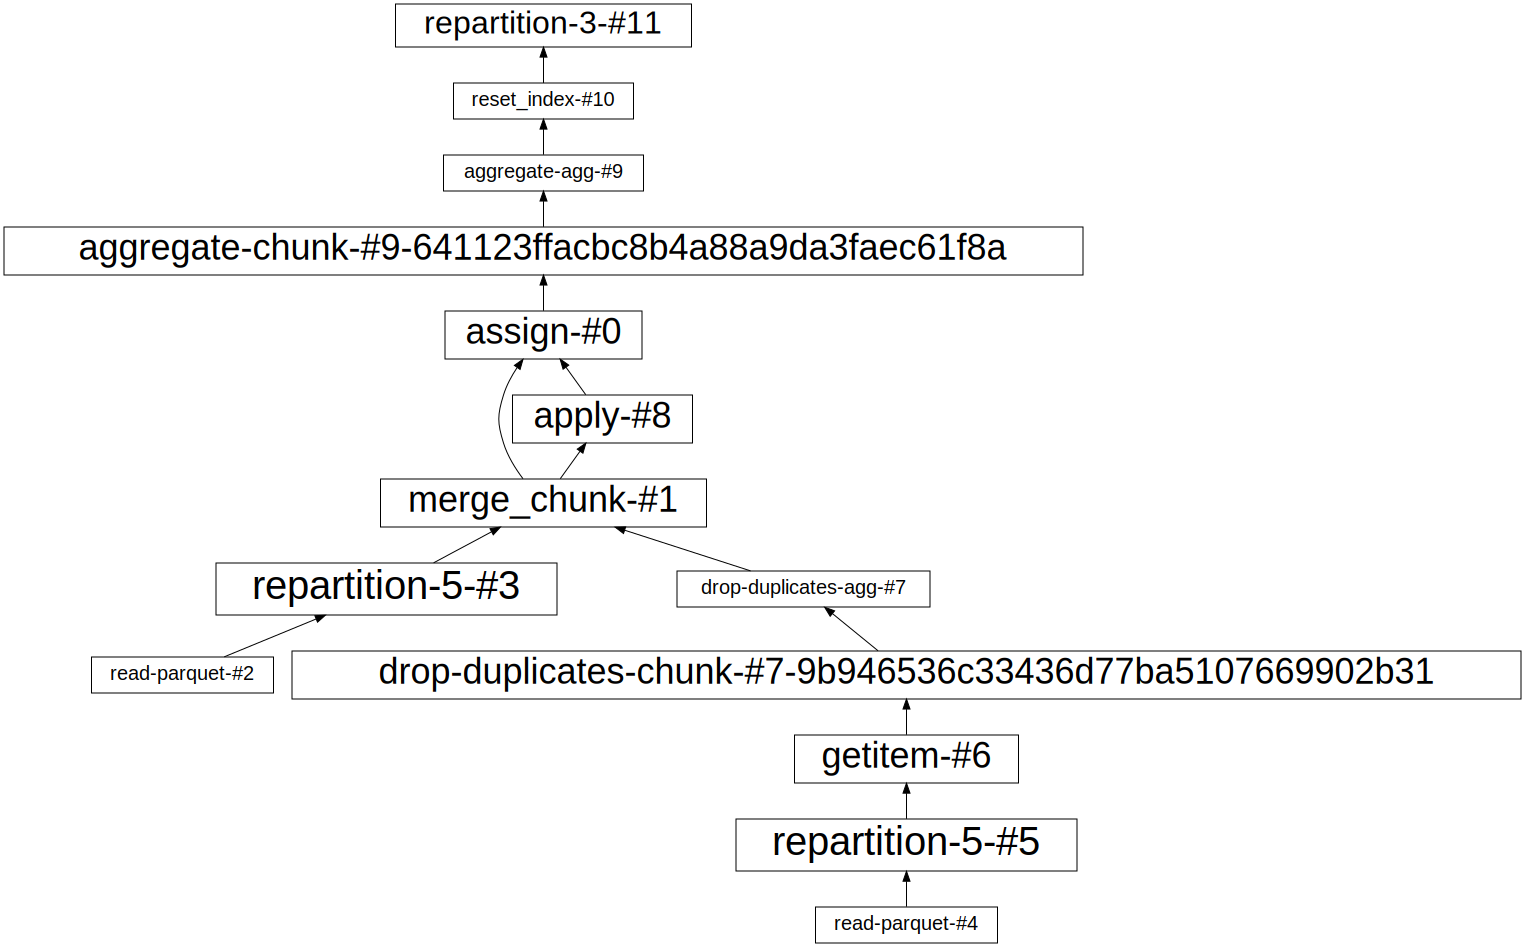

In [10]:
# High-level graph - looks good, repartitioning worked
merged.dask.visualize()

In [11]:
# This takes awhile, subset to 1 operator and save
df = merged[merged.calitp_itp_id==183]

In [12]:
fs = get_fs()
df.to_parquet(
    "gs://calitp-analytics-data/data-analyses/dask_test/test.parquet",
    storage_options={'token': fs.credentials.credentials}
)

[Slack thread](https://cal-itp.slack.com/archives/C01FNDG1ZPA/p1669661632210899?thread_ts=1669143674.718639&cid=C01FNDG1ZPA)

We’re being bitten by gcsfs regressions that I’ve already encountered once https://github.com/cal-itp/data-infra/pull/1693
I installed **`gcsfs==2022.5.0`** on my jupyter, restarted the kernel, and tested with this snippet successfully.

I’ll get the Jupyter image updated with the old working gcsfs version; the reason for `fs.credentials.credentials` is to get the underlying `google.oauth2.credentials.Credentials` rather than `gcsfs.credentials.GoogleCredentials`.

Test this method! 
https://github.com/pangeo-data/pangeo/issues/209

Dealing with `ClientSession` has no attribute `credentials` GH issue- https://github.com/fsspec/gcsfs/issues/180

In [ ]:
# specify project again...seems to have trouble locating credentials
'''
PROJECT = "cal-itp-data-infra"
gcs = gcsfs.GCSFileSystem(project=PROJECT)

df.to_parquet(
    "gs://calitp-analytics-data/data-analyses/dask_test/test.parquet", 
    storage_options={'token': gcs.session.credentials, 
                     'project': PROJECT}
)
'''

In [ ]:
#df.to_parquet("test")